In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score,roc_auc_score
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [2]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
combine=train.append(test)

In [8]:
px.box(combine,x="FoodCourt",template="plotly_dark")

In [9]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [10]:
# if passenger was in CryoSleep, expenses must be 0

combine.loc[:,Expenses_columns]=combine.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [11]:
combine['Expenses'] = combine.loc[:,Expenses_columns].sum(axis=1)
combine.loc[:,['CryoSleep']]=combine.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [12]:
combine[combine.Cabin.isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False,908.0
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Book Trad,True,0.0
103,0110_01,Europa,False,NaN,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,Graviph Aloubtled,False,5109.0
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,Diedow Resty,False,1048.0
227,0244_01,Mars,True,NaN,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Froos Sad,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,9138_01,Europa,NaN,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,Misamak Trupistic,NaN,3888.0
4248,9223_01,Mars,True,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Weessh Sun,NaN,0.0
4249,9223_02,Mars,True,NaN,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,Perit Sun,NaN,0.0
4258,9238_05,Earth,True,NaN,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,Caseye Emenez,NaN,0.0


In [13]:
surnames=combine.Name.map(lambda x: "".join(x.split(' ')[-1]) if pd.notnull(x) else np.nan)
surnames.value_counts()[surnames.value_counts() >10]

Buckentry      19
Belley         19
Hinglendez     18
Fowlesterez    18
Casonston      18
               ..
Wolffy         11
Rigginsen      11
Coolerson      11
Hamberterry    11
Dal            11
Name: Name, Length: 168, dtype: int64

In [14]:
combine.Name = combine.Name.map(lambda x: "".join(x.split(' ')[-1]) if pd.notnull(x) else np.nan)

In [15]:
(combine.Name.value_counts()<3).sum()

529

In [16]:
combine.Name

0         Ofracculy
1             Vines
2            Susent
3            Susent
4       Santantines
           ...     
4272          Peter
4273        Scheron
4274           Pore
4275         Conale
4276      Leonzaley
Name: Name, Length: 12970, dtype: object

In [17]:
b=combine.Cabin.apply(lambda x: "".join(x.split('/')[1]) if pd.notnull(x)  else np.nan)
b.value_counts() 

82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: Cabin, Length: 1894, dtype: int64

In [18]:
combine["ID"] =combine.PassengerId.str.split("_",expand=True)[1]
combine.loc[:,['Cabin_1']] = combine.Cabin.str.split("/",expand=True).iloc[:,0]
combine.loc[:,['Cabin_3']] = combine.Cabin.str.split("/",expand=True).iloc[:,2]

In [19]:
combine.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,ID,Cabin_1,Cabin_3
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Ofracculy,False,0.0,01,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Vines,True,736.0,01,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Susent,False,10383.0,01,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Susent,False,5176.0,02,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Santantines,True,1091.0,01,F,S


In [20]:
combine.drop(["PassengerId","Cabin"],axis=1,inplace=True)

In [21]:
pd.crosstab(combine.HomePlanet,combine.Transported) # dont need mars

Transported,False,True
HomePlanet,,
Earth,2651,1951
Europa,727,1404
Mars,839,920


In [22]:
pd.crosstab(combine.CryoSleep,combine.Transported)

Transported,False,True
CryoSleep,,
False,3650,1789
True,581,2554


In [23]:
pd.crosstab(combine.Destination,combine.Transported) #drop PSO J318.5-22

Transported,False,True
Destination,,
55 Cancri e,702,1098
PSO J318.5-22,395,401
TRAPPIST-1e,3128,2787


In [24]:
pd.crosstab(combine.VIP,combine.Transported) #drop

Transported,False,True
VIP,,
False,4093,4198
True,123,76


In [25]:
pd.crosstab(combine.Cabin_1,combine.Transported) # drop A,G,T

Transported,False,True
Cabin_1,,
A,129,127
B,207,572
C,239,508
D,271,207
E,563,313
F,1565,1229
G,1238,1321
T,4,1


In [26]:
pd.crosstab(combine.Cabin_3,combine.Transported)

Transported,False,True
Cabin_3,,
P,2308,1898
S,1908,2380


In [27]:
pd.crosstab(combine.ID,combine.Transported) # drop 7,8 comb 2,3,4,5,6

Transported,False,True
ID,,
01,3258,2959
02,623,789
03,218,353
04,94,137
05,58,70
06,34,41
07,23,23
08,7,6


In [28]:
combine.isnull().sum()

HomePlanet       288
CryoSleep        174
Destination      274
Age              270
VIP              296
RoomService      170
FoodCourt        180
ShoppingMall     175
Spa              177
VRDeck           177
Name             294
Transported     4277
Expenses           0
ID                 0
Cabin_1          299
Cabin_3          299
dtype: int64

In [29]:
numeric=combine.select_dtypes(include="number")
numeric=list(numeric.columns)
numeric

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Expenses']

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
imp_missforest = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    max_iter=20
)

combine[numeric]= imp_missforest.fit_transform(combine[numeric])

In [31]:
combine.isnull().sum()

HomePlanet       288
CryoSleep        174
Destination      274
Age                0
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
Expenses           0
ID                 0
Cabin_1          299
Cabin_3          299
dtype: int64

In [33]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Cabin_1','VIP','HomePlanet',"Name",'Destination',"Cabin_3"]
transported=['Transported']

cat_imp = SimpleImputer(strategy='most_frequent')


combine[cat_cols] = pd.DataFrame(cat_imp.fit_transform(combine[cat_cols]),columns=cat_cols)
combine.Cabin_3.fillna("P",inplace=True)

In [34]:
combine.isnull().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
Expenses           0
ID                 0
Cabin_1            0
Cabin_3            0
dtype: int64

In [35]:
combine.drop(["Name","VIP"],axis=1,inplace=True)

In [ ]:
train = combine[combine['Transported'].notnull()]
train.Transported =train.Transported.astype('int')
test = combine[combine['Transported'].isnull()].drop("Transported",axis=1)

In [37]:
from sklearn.model_selection import train_test_split,cross_val_score
X = train.drop('Transported',axis=1)
y = train.Transported

X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [38]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenses', 'ID',
       'Cabin_1', 'Cabin_3'],
      dtype='object')

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>],
       [<Axes: title={'center': 'Expenses'}>, <Axes: >, <Axes: >]],
      dtype=object)

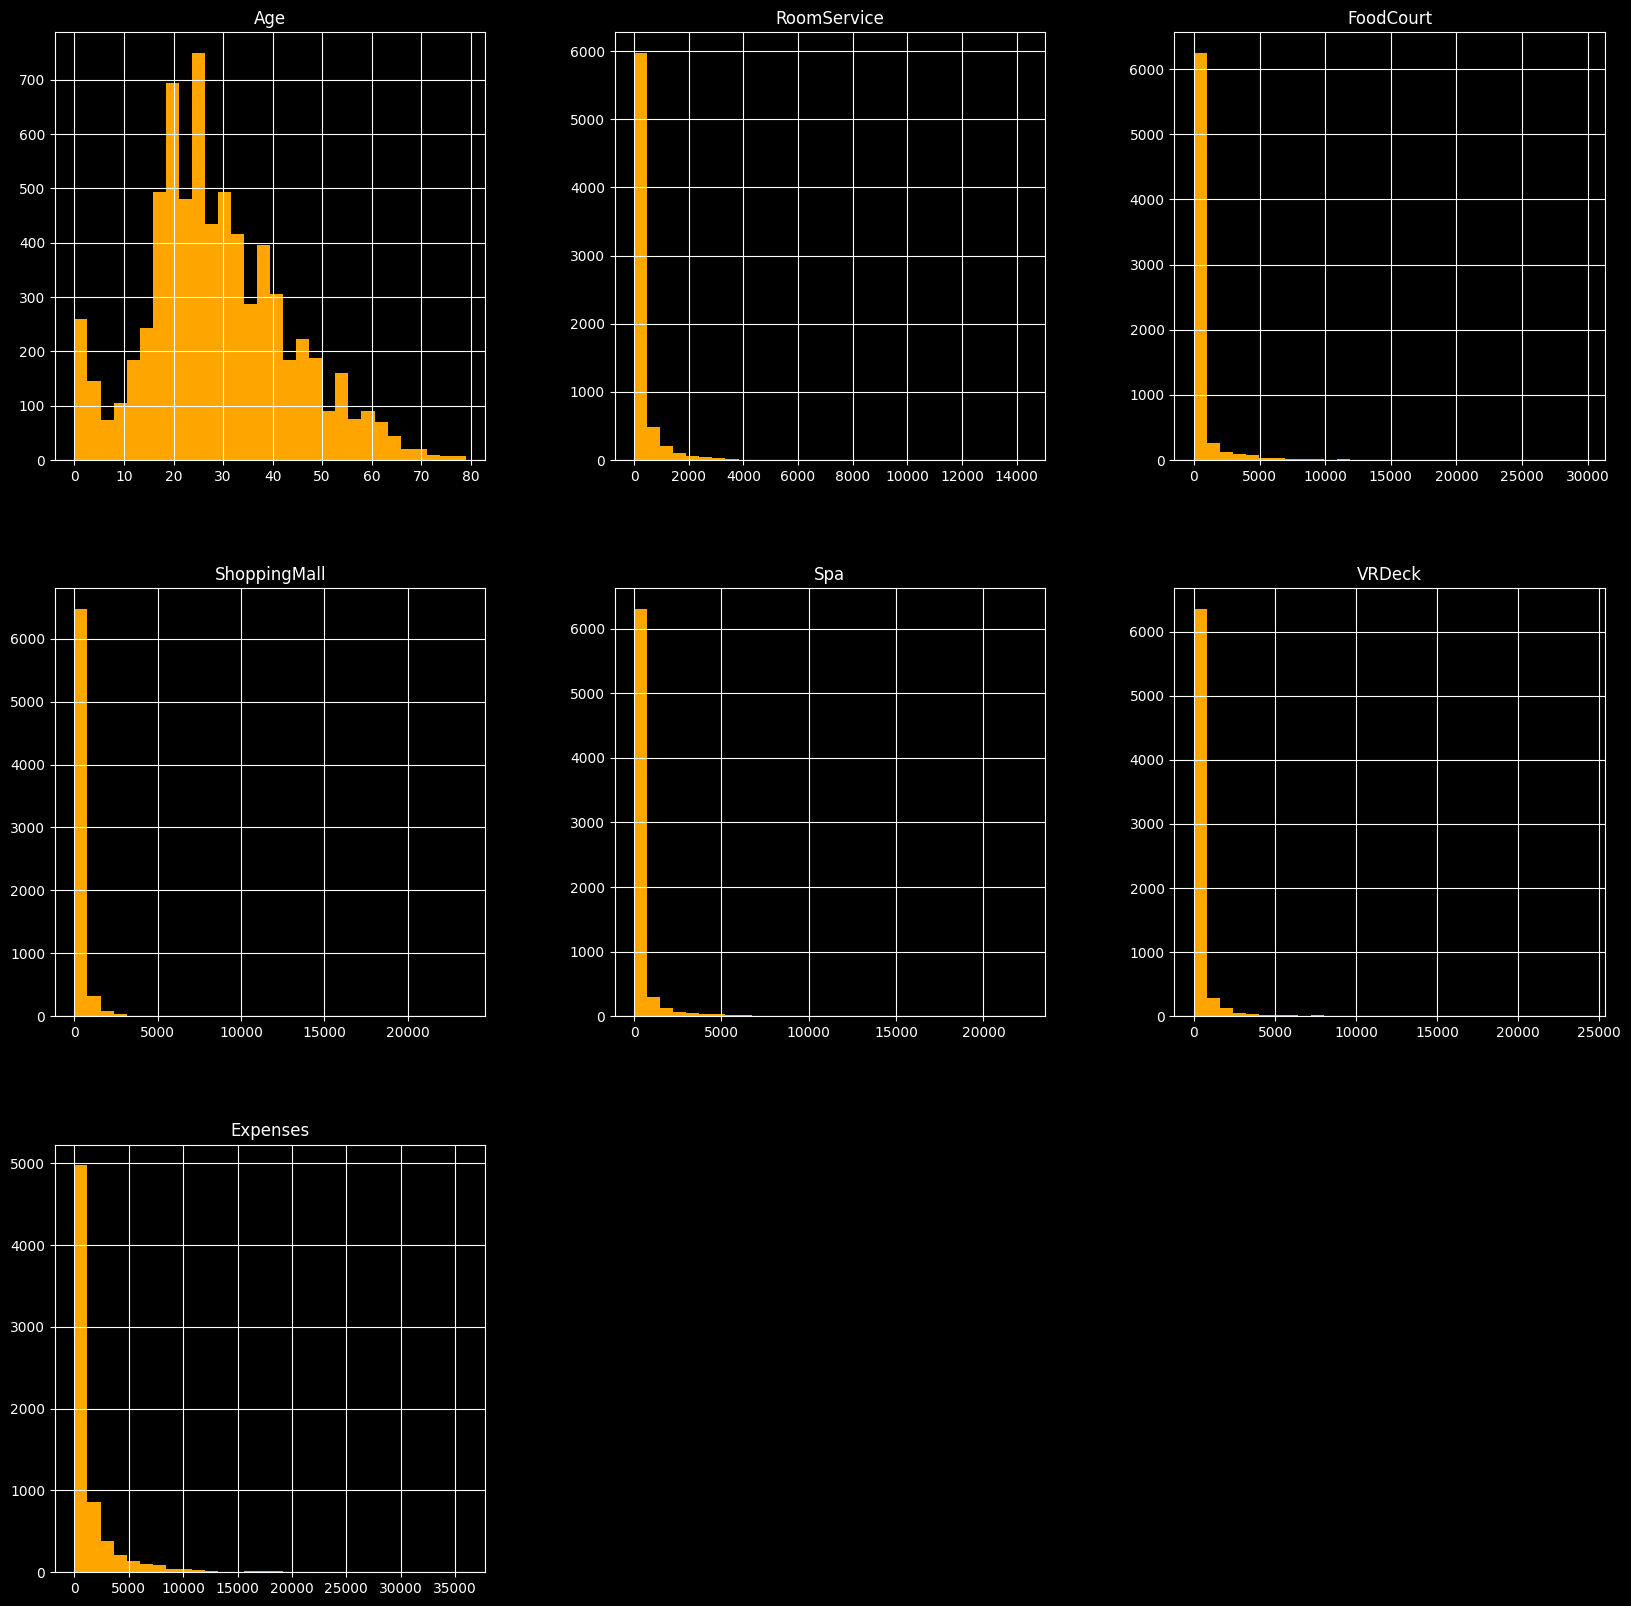

In [39]:
plt.style.use("dark_background")
X_train.hist(bins=30,color="orange",figsize=(20,20))

In [41]:
from feature_engine.transformation import YeoJohnsonTransformer
yeo = YeoJohnsonTransformer(variables=num_cols)
yeo.fit(X_train)
X_train = yeo.transform(X_train)
X_test = yeo.transform(X_test)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RoomService'}>,
        <Axes: title={'center': 'FoodCourt'}>],
       [<Axes: title={'center': 'ShoppingMall'}>,
        <Axes: title={'center': 'Spa'}>,
        <Axes: title={'center': 'VRDeck'}>],
       [<Axes: title={'center': 'Expenses'}>, <Axes: >, <Axes: >]],
      dtype=object)

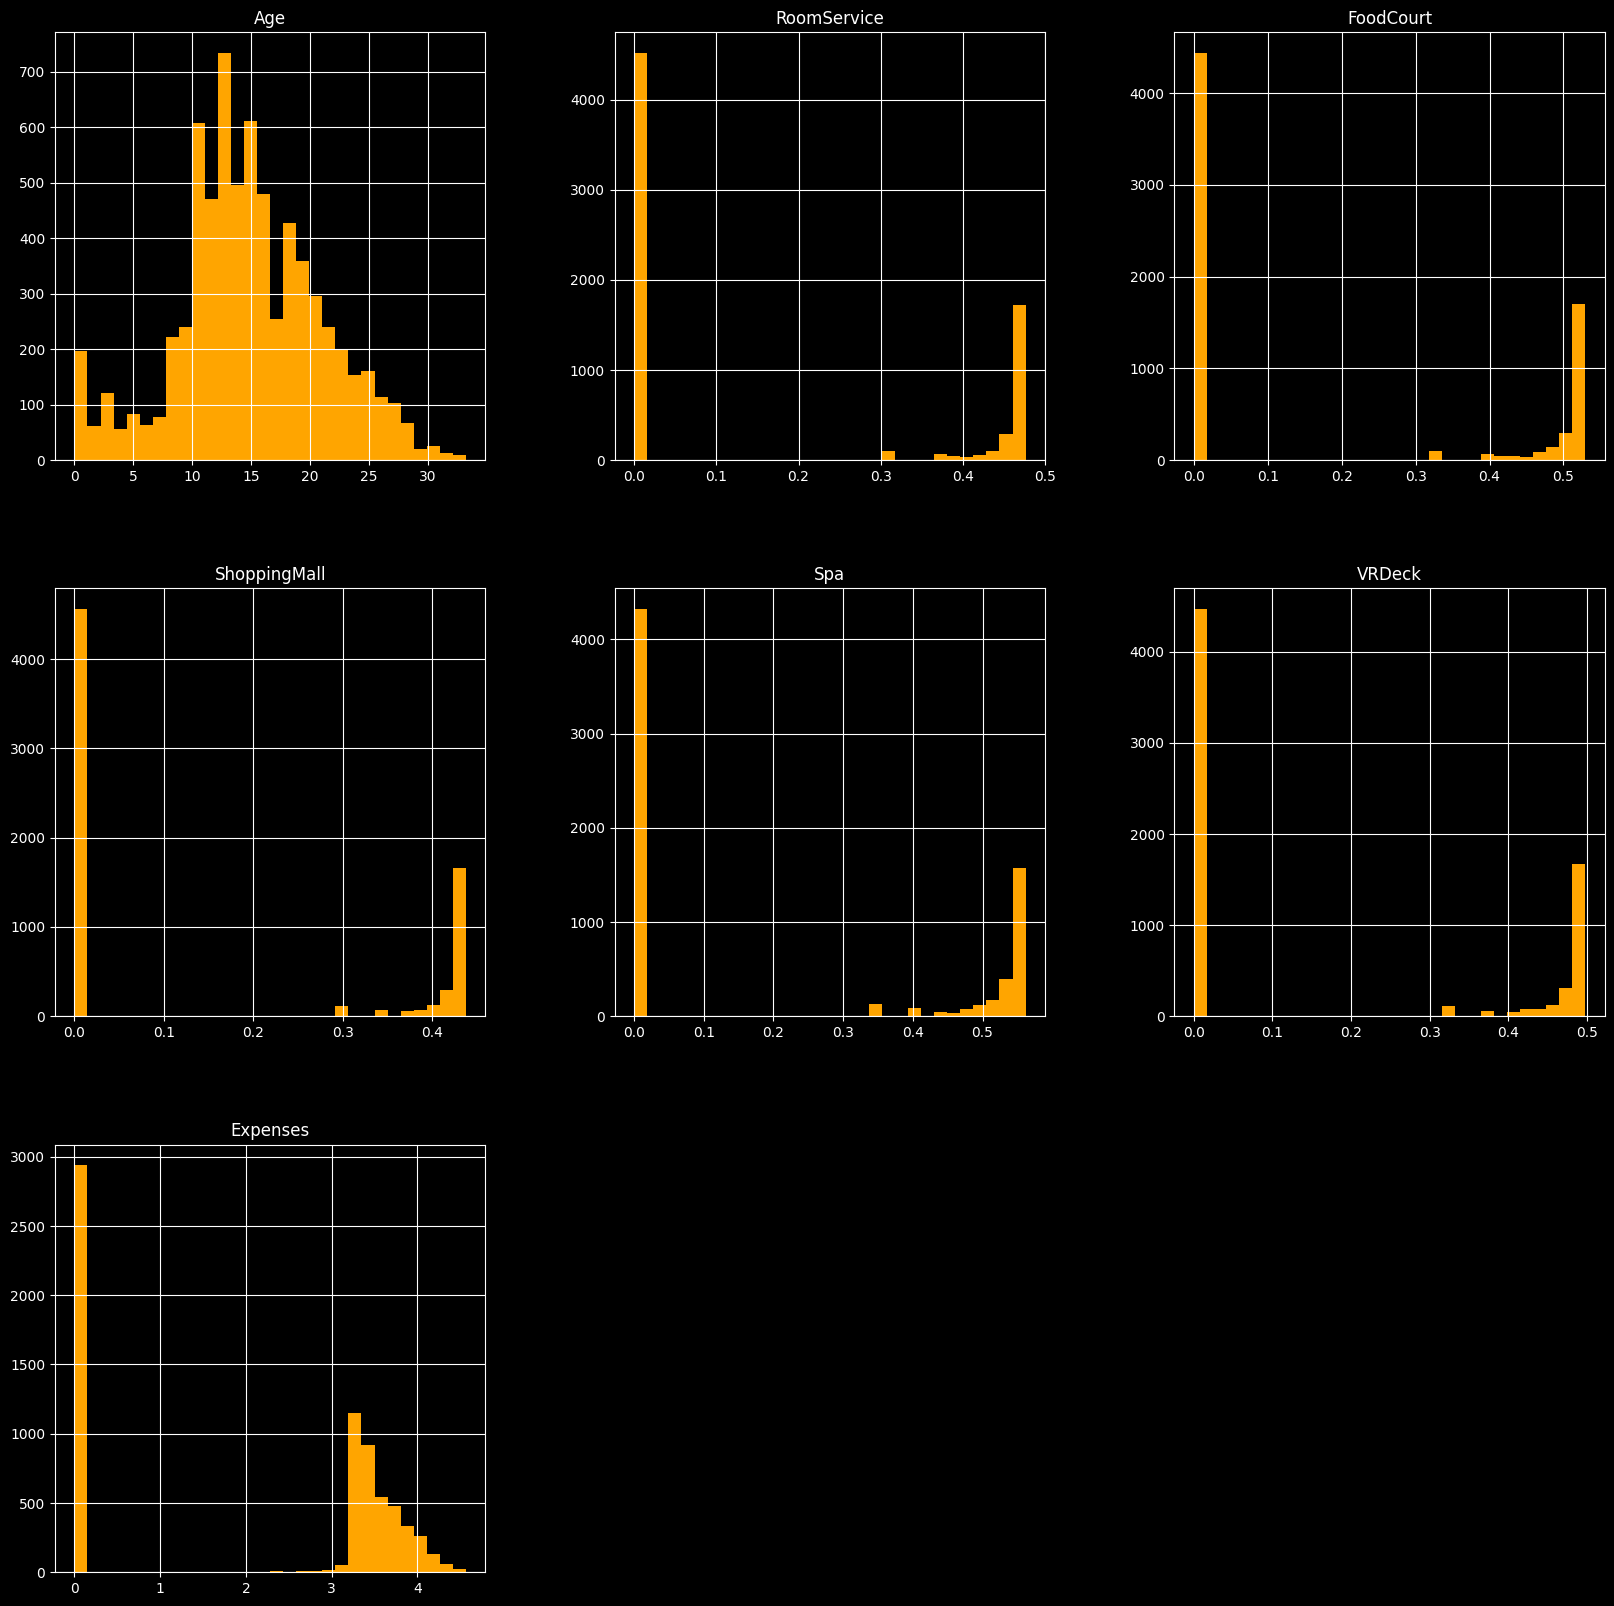

In [42]:
X_train.hist(bins=30,color="orange",figsize=(20,20))

In [43]:
X_train

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenses,ID,Cabin_1,Cabin_3
1032,Earth,False,TRAPPIST-1e,19.727164,0.472761,-0.000000,0.432534,-0.000000,-0.000000,3.372935,01,G,S
3870,Earth,True,TRAPPIST-1e,11.041073,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,01,G,S
4320,Earth,False,PSO J318.5-22,17.793141,-0.000000,-0.000000,0.349368,0.555028,0.453911,3.275100,01,F,P
3143,Europa,False,TRAPPIST-1e,23.061564,-0.000000,0.526227,-0.000000,0.547718,0.495361,3.842038,01,E,S
5488,Mars,False,55 Cancri e,11.496611,0.472294,0.469885,0.435681,0.471960,0.481194,3.626141,04,E,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8619,Earth,True,PSO J318.5-22,12.391192,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,01,G,P
4651,Mars,True,TRAPPIST-1e,7.658940,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,01,F,S
2992,Earth,False,TRAPPIST-1e,13.265758,0.472294,0.328946,-0.000000,0.549901,-0.000000,3.322563,01,G,S
1346,Earth,False,55 Cancri e,11.496611,-0.000000,0.527155,0.399398,-0.000000,0.482608,3.791842,01,F,P


In [44]:
X_train.ID.value_counts()

01    5003
02    1106
03     450
04     188
05     101
06      61
07      35
08      10
Name: ID, dtype: int64

In [45]:
X_test.ID.value_counts()

01    1214
02     306
03     121
04      43
05      27
06      14
07      11
08       3
Name: ID, dtype: int64

In [46]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenses', 'ID',
       'Cabin_1', 'Cabin_3'],
      dtype='object')

In [48]:
from feature_engine.encoding import RareLabelEncoder
rare_enc = RareLabelEncoder(
    tol=0.05,
    n_categories=1,
    variables=["ID","Cabin_1"]
)   
rare_enc.fit(X_train)
rare_enc.variables

['ID', 'Cabin_1']

In [50]:
X_train = rare_enc.transform(X_train)
X_test = rare_enc.transform(X_test)


In [51]:
X_train.ID.value_counts()

01      5003
02      1106
03       450
Rare     395
Name: ID, dtype: int64

In [52]:
cat_cols = ['CryoSleep',
 'Cabin_1',
 'HomePlanet',
 'Destination',
 'Cabin_3',
 'Cabin_2']

In [53]:
X_train.CryoSleep = X_train.CryoSleep.astype(int)
X_test.CryoSleep = X_test.CryoSleep.astype(int)

In [54]:
X_train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenses', 'ID',
       'Cabin_1', 'Cabin_3'],
      dtype='object')

In [57]:
cat_cols = ['Cabin_1', 'HomePlanet', 'Destination', 'Cabin_3',"ID"]

In [58]:
X_train_encoded = pd.get_dummies(X_train,columns=cat_cols,drop_first=True)
X_test_encoded=pd.get_dummies(X_test,columns=cat_cols,drop_first=True)

In [59]:
X_train_encoded

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenses,Cabin_1_C,Cabin_1_D,...,Cabin_1_G,Cabin_1_Rare,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_3_S,ID_02,ID_03,ID_Rare
1032,0,19.727164,0.472761,-0.000000,0.432534,-0.000000,-0.000000,3.372935,0,0,...,1,0,0,0,0,1,1,0,0,0
3870,1,11.041073,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0,0,...,1,0,0,0,0,1,1,0,0,0
4320,0,17.793141,-0.000000,-0.000000,0.349368,0.555028,0.453911,3.275100,0,0,...,0,0,0,0,1,0,0,0,0,0
3143,0,23.061564,-0.000000,0.526227,-0.000000,0.547718,0.495361,3.842038,0,0,...,0,0,1,0,0,1,1,0,0,0
5488,0,11.496611,0.472294,0.469885,0.435681,0.471960,0.481194,3.626141,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8619,1,12.391192,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0,0,...,1,0,0,0,1,0,0,0,0,0
4651,1,7.658940,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0,0,...,0,0,0,1,0,1,1,0,0,0
2992,0,13.265758,0.472294,0.328946,-0.000000,0.549901,-0.000000,3.322563,0,0,...,1,0,0,0,0,1,1,0,0,0
1346,0,11.496611,-0.000000,0.527155,0.399398,-0.000000,0.482608,3.791842,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
from feature_engine.selection import SelectByShuffling
rf = RandomForestClassifier(n_estimators=300)
sel = SelectByShuffling(
    estimator=rf,
    scoring="roc_auc",
    cv=10,
    random_state=1
)
sel.fit(X_train_encoded,y_train)

SelectByShuffling(cv=10, estimator=RandomForestClassifier(n_estimators=300),
                  random_state=1)

In [61]:
pd.Series(sel.performance_drifts_).sort_values()

Destination_PSO J318.5-22   -0.001843
Cabin_1_D                   -0.000940
ID_Rare                     -0.000512
ID_03                       -0.000391
ID_02                       -0.000325
Cabin_1_Rare                 0.000164
Age                          0.000760
Cabin_1_C                    0.001273
Destination_TRAPPIST-1e      0.001732
Cabin_1_E                    0.001923
Cabin_1_G                    0.002806
Cabin_1_F                    0.004967
HomePlanet_Europa            0.005136
Cabin_3_S                    0.005630
HomePlanet_Mars              0.007331
ShoppingMall                 0.007393
RoomService                  0.019041
FoodCourt                    0.024965
Expenses                     0.025699
VRDeck                       0.027116
Spa                          0.030658
CryoSleep                    0.035802
dtype: float64

In [62]:
X_train_selected = X_train_encoded.drop(["Destination_PSO J318.5-22","Cabin_1_D","ID_Rare","Cabin_1_Rare","ID_02","ID_03","Age","Cabin_1_C"],axis=1)
X_test_selected = X_test_encoded.drop(["Destination_PSO J318.5-22","Cabin_1_D","ID_Rare","Cabin_1_Rare","ID_02","ID_03","Age","Cabin_1_C"],axis=1)

In [63]:
from xgboost import XGBClassifier
xg = XGBClassifier(objective="binary:logistic")

In [64]:
xg.fit(X_train_selected,y_train)
ypred = xg.predict(X_test_selected)
roc_auc_score(y_test,ypred)

0.8122933168251348

In [65]:
cross_val_score(xg,X_train_selected,y_train,n_jobs=-1,scoring="roc_auc",cv=20).mean()

0.8793878705080542

In [69]:
X_train_selected.shape

(6954, 14)

In [ ]:
X_train_selected2

In [66]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
rf= RandomForestClassifier(n_estimators=300)
sbs = SFS(estimator=rf, 
           k_features=1, 
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='roc_auc',
           cv=10,
           n_jobs=-1)

sbs = sbs.fit(X_train_selected, y_train)

pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
14,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)","[0.8803055326176714, 0.8670767960363337, 0.875...",0.880178,"(CryoSleep, RoomService, FoodCourt, ShoppingMa...",0.008626,0.011614,0.003871
13,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13)","[0.8819735755573905, 0.8680388109000826, 0.873...",0.880065,"(CryoSleep, RoomService, FoodCourt, ShoppingMa...",0.007981,0.010745,0.003582
12,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13)","[0.8802848885218828, 0.8689099917423617, 0.868...",0.879864,"(CryoSleep, RoomService, FoodCourt, ShoppingMa...",0.008591,0.011567,0.003856
11,"(0, 1, 2, 4, 5, 6, 7, 9, 11, 12, 13)","[0.8768001651527664, 0.864570602807597, 0.8694...",0.878205,"(CryoSleep, RoomService, FoodCourt, Spa, VRDec...",0.008779,0.01182,0.00394
10,"(1, 2, 4, 5, 6, 7, 9, 11, 12, 13)","[0.8735507844756399, 0.8652023121387282, 0.865...",0.8767,"(RoomService, FoodCourt, Spa, VRDeck, Expenses...",0.009234,0.012433,0.004144
9,"(1, 4, 5, 6, 7, 9, 11, 12, 13)","[0.8718951279933939, 0.8617960363336086, 0.864...",0.875207,"(RoomService, Spa, VRDeck, Expenses, Cabin_1_E...",0.010325,0.013902,0.004634
8,"(0, 1, 4, 5, 6, 7, 9, 11)","[0.8711932287365813, 0.8556523534269199, 0.859...",0.872383,"(CryoSleep, RoomService, Spa, VRDeck, Expenses...",0.009233,0.012431,0.004144
7,"(1, 4, 5, 6, 7, 9, 11)","[0.8641123038810901, 0.8529479768786126, 0.852...",0.869348,"(RoomService, Spa, VRDeck, Expenses, Cabin_1_E...",0.0104,0.014002,0.004667
6,"(2, 3, 6, 7, 9, 13)","[0.8675516102394715, 0.8471552436003302, 0.859...",0.864879,"(FoodCourt, ShoppingMall, Expenses, Cabin_1_E,...",0.009307,0.012531,0.004177
5,"(2, 3, 6, 7, 9)","[0.8624401321222132, 0.8409702725020645, 0.848...",0.861837,"(FoodCourt, ShoppingMall, Expenses, Cabin_1_E,...",0.011171,0.01504,0.005013


In [154]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)["feature_idx"].loc[15]

(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

In [70]:
X_train_selected2=X_train_selected.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]]
X_test_selected2 = X_test_selected.iloc[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]]

<Axes: >

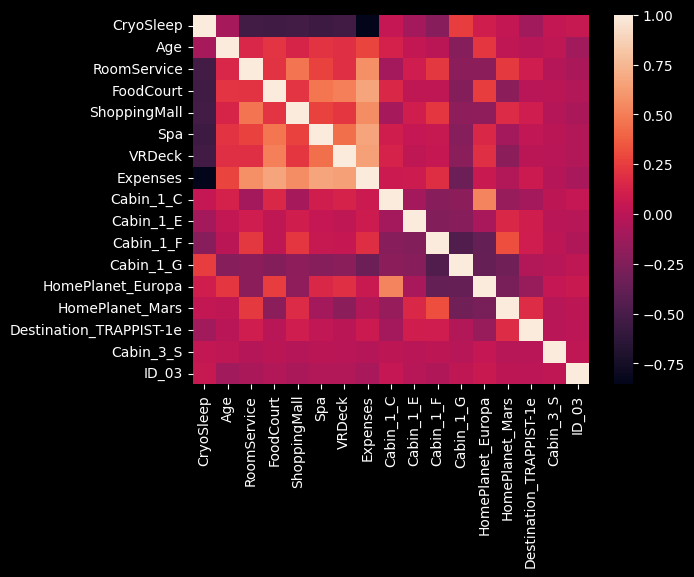

In [144]:
import seaborn as sns
sns.heatmap(X_train_selected.corr())

In [88]:
X_train_selected2.columns

Index(['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Expenses', 'Cabin_1_E', 'Cabin_1_F', 'Cabin_1_G',
       'HomePlanet_Mars', 'Destination_TRAPPIST-1e', 'Cabin_3_S'],
      dtype='object')

In [89]:
cat_cols=['CryoSleep','Cabin_1_E','Cabin_1_F', 'Cabin_1_G',
       'HomePlanet_Mars', 'Destination_TRAPPIST-1e', 'Cabin_3_S']

In [95]:
nums=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Expenses']

In [90]:
from sklearn.feature_selection import mutual_info_classif,SelectFromModel
cats = []
for col in cat_cols:
    score = mutual_info_classif(X_train_selected2[col].to_frame(),y_train)
    cats.append(score)
pd.DataFrame(cats,index=cat_cols)

,0
CryoSleep,0.117588
Cabin_1_E,0.008730
Cabin_1_F,0.002326
Cabin_1_G,0.006089
HomePlanet_Mars,0.005967
Destination_TRAPPIST-1e,0.003999
Cabin_3_S,0.000000


In [99]:
pd.crosstab(X_train_selected2.Cabin_1_G,y_train)

Transported,0,1
Cabin_1_G,,
0,2442,2438
1,1010,1064


In [97]:
from sklearn.feature_selection import mutual_info_classif,SelectFromModel
cats = []
for col in nums:
    score = mutual_info_classif(X_train_selected2[col].to_frame(),y_train)
    cats.append(score)
pd.DataFrame(cats,index=nums)

,0
RoomService,0.076306
FoodCourt,0.037842
ShoppingMall,0.053978
Spa,0.077027
VRDeck,0.063343
Expenses,0.132650


In [92]:
from sklearn.feature_selection import SelectKBest,f_classif

sel=SelectKBest(f_classif,k="all").fit(X_train_selected2[cat_cols],y_train)
pd.DataFrame(sel.scores_,index=cat_cols).sort_values(by=0,ascending=False)

,0
CryoSleep,1948.172241
Destination_TRAPPIST-1e,67.496582
Cabin_3_S,67.245682
Cabin_1_E,61.054951
Cabin_1_F,52.072372
HomePlanet_Mars,2.820802
Cabin_1_G,1.049697


In [98]:
from sklearn.feature_selection import SelectKBest,f_classif

sel=SelectKBest(f_classif,k="all").fit(X_train_selected2[nums],y_train)
pd.DataFrame(sel.scores_,index=nums).sort_values(by=0,ascending=False)

,0
Expenses,2000.632852
Spa,1085.250746
RoomService,1037.308584
VRDeck,906.197440
ShoppingMall,537.923770
FoodCourt,375.491963


In [ ]:
X_train_selected2.drop(["Cabin_1_G","HomePlanet_Mars"],axis=1,inplace=True)
X_test_selected2.drop(["Cabin_1_G","HomePlanet_Mars"],axis=1,inplace=True)

In [104]:
import optuna

In [ ]:
def objective(trial):
    
    param = { 
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400,1200),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        }
    
    xgb = XGBClassifier(**param,tree_method='gpu_hist', gpu_id=0
        )

    score = cross_val_score(xgb, X_train_selected2, y_train, n_jobs=-1, cv=10,scoring="roc_auc")
    roc_auc = score.mean()
    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
study.optimize(objective, n_trials=70)

In [102]:
trial = study.best_trial
print(trial.value)
print(trial.params)

0.8873776563118358
{'lambda': 1.0432674565121445, 'alpha': 2.0713162283779827, 'colsample_bytree': 0.773079358594553, 'subsample': 0.974873500601664, 'learning_rate': 0.091922371607278, 'n_estimators': 417, 'max_depth': 3, 'min_child_weight': 2}


In [105]:
xgbc = XGBClassifier(**trial.params)

In [107]:
xgbc.fit(X_train_selected2,y_train)
ypred = xgbc.predict(X_test_selected2)
recall_score(y_test,ypred)

0.8310502283105022

In [108]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, ypred)

array([[676, 187],
       [148, 728]], dtype=int64)

In [109]:
#after that set threshold 